# Gaussian Process Regression

In [7]:
import warnings
from itertools import combinations
import pickle

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats.qmc import LatinHypercube, scale
from scipy.interpolate import LinearNDInterpolator

from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning

In [3]:
%load_ext autoreload
%autoreload 2
from common import *
from metrics import *
from shifty_kernels import ProjectionKernel, ConstantKernel, RBF, SymmetricKernel1D
from gaussian_process import NoiseFittedGP

In [4]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [5]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=True
save_dir = "../../../tex/03_gaussian_process_regression/img/"

## Analyzing the Dataset (Friedman Function)

In [5]:
dim = 5
sigma = .7
N_train = 700
X_train = LatinHypercube(dim).random(N_train)
y_train = noisy_friedman(X_train, sigma=sigma)
y_train_mean = np.mean(y_train)
y_train = y_train - y_train_mean

In [6]:
N_test = 700
X_test = LatinHypercube(dim).random(N_test)
y_test = noisy_friedman(X_test, sigma=sigma)
y_test = y_test - y_train_mean

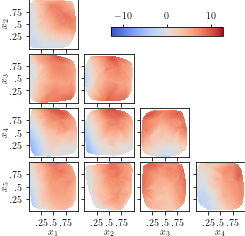

In [14]:
def my_formatter(x, pos):
    val_str = '{:g}'.format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str
    
interp = LinearNDInterpolator(X_train, y_train)
fig, ax = plt.subplots(nrows=dim - 1, ncols=dim - 1, figsize=(3.9,3.9), 
                       sharex=True, sharey=True)
planes = list(combinations(np.arange(5),2))
    
M = 100
dim = 5
x = y = np.linspace(0,1,M)
xx, yy = np.meshgrid(x,y)
fmax = np.max(y_train)
fmin = np.min(y_train)
halfrange=max(np.abs(fmin), np.abs(fmax))

major_formatter = FuncFormatter(my_formatter)
x_cross = 0.75
for plane_coordinates in planes:
    x = np.linspace(np.min(X_train[:,plane_coordinates[0]]),np.max(X_train[:,plane_coordinates[0]]),M)
    y = np.linspace(np.min(X_train[:,plane_coordinates[1]]),np.max(X_train[:,plane_coordinates[1]]),M)
    
    xx, yy = np.meshgrid(x,y)
    X = x_cross * np.ones((M*M,dim))
    X[:,plane_coordinates[0]] = xx.flatten()
    X[:,plane_coordinates[1]] = yy.flatten()
    fxy = interp(X).reshape(M,M)
    
    i, j = plane_coordinates[1] - 1, plane_coordinates[0]

    ax[i,j].grid(False)
    ax[i,j].set_box_aspect(1)
    im = ax[i,j].pcolormesh(xx,yy,fxy, cmap="coolwarm",
                      rasterized=True,
                      norm=colors.CenteredNorm(halfrange=halfrange))
    
    ax[i,j].xaxis.set_ticks(np.arange(0.25, 1, 0.25))
    ax[i,j].yaxis.set_ticks(np.arange(0.25, 1, 0.25))
    ax[i,j].xaxis.set_major_formatter(major_formatter)
    ax[i,j].yaxis.set_major_formatter(major_formatter)
    
ax[0,0].set_xlim([0,1])
ax[0,0].set_ylim([0,1])

for j in range(dim-1):
    ax[-1,j].set_xlabel(rf"$x_{j+1}$", color="k")
    ax[-1,j].xaxis.labelpad=0
    
for i in range(dim-1):
    ax[i,0].set_ylabel(rf"$x_{i+2}$", color="k")
    ax[i,0].yaxis.labelpad=0
    
for a in ax[np.triu_indices(dim - 1, 1)]:
    a.axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.42, 0.75, 0.4, 0.03])
cbar_ax.grid(False)

fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_label_position('top') 
cbar_ax.xaxis.tick_top()
cbar_ax.set_ylabel(r"y (interpolated)")

if save:
    fig.savefig(save_dir + f"friedman_crossections_x_{x_cross:.2f}.pdf",
                bbox_inches="tight",dpi=1000,pad_inches = 0.01)
else:
    plt.show()

## Kernel Comparison

In [7]:
sqexp = ConstantKernel(constant_value=1) * RBF(length_scale=[0.1])
coupling = ProjectionKernel(sqexp, P(dim, 0), tag="x0") * ProjectionKernel(sqexp, P(dim, 1), tag="x1")
kernels = {
    "sq_exp":sqexp,
    "sq_exp_ard":(ConstantKernel(constant_value=1) * RBF(length_scale=dim * [0.1])),
    "sq_exp_i12345":  ProjectionKernel(sqexp, P(dim, 0), tag="x1") \
                         + ProjectionKernel(sqexp, P(dim, 1), tag="x2") \
                         + ProjectionKernel(sqexp, P(dim, 2), tag="x3") \
                         + ProjectionKernel(sqexp, P(dim, 3), tag="x4") \
                         + ProjectionKernel(sqexp, P(dim, 4), tag="x5"),
    "sq_exp_c12_i345":  coupling + ProjectionKernel(sqexp, P(dim, 2), tag="x3") \
                                              + ProjectionKernel(sqexp, P(dim, 3), tag="x4") \
                                              + ProjectionKernel(sqexp, P(dim, 4), tag="x5"),
    "sq_exp_c12_s3_i45":  coupling + SymmetricKernel1D(ProjectionKernel(sqexp, P(dim, 2), tag="x3"), offset=0.5) \
                                                   + ProjectionKernel(sqexp, P(dim, 3), tag="x4") \
                                                   + ProjectionKernel(sqexp, P(dim, 4), tag="x5")
}


In [37]:
hyperparameters = {
    "n_restarts_optimizer": 9
}
prediction_error={}
prediction_error_std={}
trained_gp={}

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

train = False
if train:
    file_prediction_error=open("../data/prediction_error", "wb")
    file_prediction_error_std = open("../data/prediction_error_std", "wb")
    
    for name, kernel in kernels.items():
            print(f"Training {name}")
            gp = NoiseFittedGP(kernel=kernel, **hyperparameters)
            prediction_error[name], prediction_error_std[name], trained_gp[name] = prediction_error_CV(squared_error, gp, 
                                                                                                       X_train, y_train, nfolds=10, return_best_predictor=True)
            trained_gp[name].save("../data/" + name)
            print(f"Trained kernel: {trained_gp[name].kernel_}")
            pickle.dump(prediction_error[name], file_prediction_error)
            pickle.dump(prediction_error_std[name], file_prediction_error_std)

else:
    file_prediction_error=open("../data/prediction_error", "rb")
    file_prediction_error_std = open("../data/prediction_error_std", "rb")
    
    for name, kernel in kernels.items():
        print(f"Loading {name} errors")
        prediction_error[name] = pickle.load(file_prediction_error)
        prediction_error_std[name] = pickle.load(file_prediction_error_std)
        
    for name, kernel in kernels.items():
        trained_gp[name] = NoiseFittedGP.load("../data/" +name)     
        print(f"Loaded kernel: {trained_gp[name].kernel_}")
            
file_prediction_error.close()
file_prediction_error_std.close()

Loading sq_exp errors
Loading sq_exp_ard errors
Loading sq_exp_i12345 errors
Loading sq_exp_c12_i345 errors
Loading sq_exp_c12_s3_i45 errors
Loaded kernel: 20.4**2 * RBF(length_scale=1.1) + WhiteKernel(noise_level=0)
Loaded kernel: 174**2 * RBF(length_scale=[1.65, 1.47, 4.02, 35.4, 68.5]) + WhiteKernel(noise_level=0)
Loaded kernel: ProjectionKernel(x1, 15.2**2 * RBF(length_scale=1.15)) + ProjectionKernel(x2, 4**2 * RBF(length_scale=0.525)) + ProjectionKernel(x3, 19.9**2 * RBF(length_scale=1.15)) + ProjectionKernel(x4, 25.7**2 * RBF(length_scale=3.71)) + ProjectionKernel(x5, 3.71**2 * RBF(length_scale=0.859)) + WhiteKernel(noise_level=0)
Loaded kernel: ProjectionKernel(x0, 0.399**2 * RBF(length_scale=0.761)) * ProjectionKernel(x1, 40.1**2 * RBF(length_scale=0.685)) + ProjectionKernel(x3, 44.7**2 * RBF(length_scale=1.79)) + ProjectionKernel(x4, 69**2 * RBF(length_scale=10.2)) + ProjectionKernel(x5, 26.6**2 * RBF(length_scale=5.76)) + WhiteKernel(noise_level=0)
Loaded kernel: ProjectionKe

### Cross validated MSE across different kernels (on validation set)

SMSE = [0.58586508 2.31088535 2.311752   0.49750221 0.49269531]
SMSE errors = [0.06833367 3.04056033 0.35606929 0.05958389 0.05869831]
Lower Bound = 0.48999999999999994


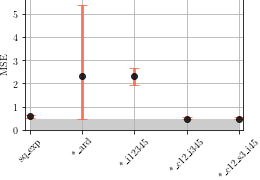

In [38]:
size = (3.9, 0.618 * 3.9) if save else (10,6)
fig, ax = plt.subplots(figsize=size)
ax.margins(0.02)

smse_kernel, smse_errors = list(prediction_error.keys()), np.array(list(prediction_error.values()))
smse_errors_std = np.array(list(prediction_error_std.values()))
print(f"SMSE = {smse_errors}")
print(f"SMSE errors = {smse_errors_std}")
print(f"Lower Bound = {sigma**2}")
smse_kernel = [smse_kernel[0]] + [kernel_name.replace("sq_exp", "*") for kernel_name in smse_kernel[1:]]

upper_error = smse_errors_std
lower_error = np.minimum(np.abs(smse_errors - sigma**2), smse_errors_std)

asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

ax.errorbar(smse_kernel, smse_errors, yerr=asymmetric_error, fmt='o', color='black',
             ecolor='tomato', elinewidth=3, capsize=5, alpha=.8);
ax.fill_between(smse_kernel, 0, sigma**2, alpha=0.4, color="gray", edgecolor=None, label=r"irreducablue noise")
ax.set_ylabel(r"$\hat\mathrm{MSE}$")
ax.set_ylim(0, 1.05*np.max(upper_error+smse_errors))
ax.xaxis.set_tick_params(rotation=45)

if save:
    fig.savefig(save_dir + f"friedman_kernel_smse.pdf",
                bbox_inches="tight",dpi=1000,pad_inches = 0.03)
else:
    plt.show()

### Regression Result for Optimized Kernel

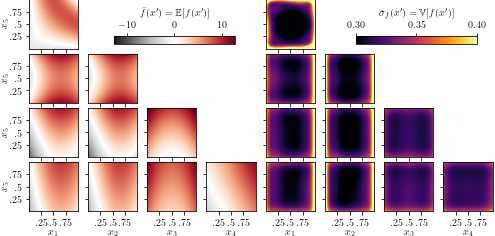

In [34]:
M = 100
dim = 5
fig, ax = plt.subplots(nrows=dim - 1, ncols=2 * (dim - 1), figsize=(8.4,3.9), 
                       sharex=True, sharey=True)
planes = list(combinations(np.arange(5),2))
x_cross=0.75
    
sigma_min = 0.3
sigma_max = 0.4
for plane_coordinates in planes:
    x = np.linspace(np.min(X_test[:,plane_coordinates[0]]),np.max(X_test[:,plane_coordinates[0]]),M)
    y = np.linspace(np.min(X_test[:,plane_coordinates[1]]),np.max(X_test[:,plane_coordinates[1]]),M)
    
    xx, yy = np.meshgrid(x,y)
    X = x_cross * np.ones((M*M,dim))
    X[:,plane_coordinates[0]] = xx.flatten()
    X[:,plane_coordinates[1]] = yy.flatten()
    f, sigma_f = trained_gp["sq_exp_c12_s3_i45"].predict(X, return_std=True)
    f = f.reshape(M,M)
    sigma_f = sigma_f.reshape(M,M)
    
    i, j = plane_coordinates[1] - 1, plane_coordinates[0]

    ax[i,j].grid(False)
    ax[i,j].set_box_aspect(1)
    ax[i,dim - 1 + j].grid(False)
    ax[i,dim - 1 + j].set_box_aspect(1)
    
    im = ax[i,j].pcolormesh(xx,yy,f, cmap="RdGy_r", 
                            norm=colors.CenteredNorm(halfrange=halfrange),
                            rasterized=True)
    im2 = ax[i, dim-1+j].pcolormesh(xx,yy,np.sqrt(sigma_f), cmap="inferno", 
                                    vmin=sigma_min, vmax=sigma_max,
                                    rasterized=True)
    
    for a in [ax[:,:dim-1], ax[:, dim-1:]]:
        a[i,j].yaxis.set_ticks(np.arange(0.25, 1, 0.25))
        a[i,j].yaxis.set_major_formatter(major_formatter)
        a[i,j].xaxis.set_ticks(np.arange(0.25, 1, 0.25))
        a[i,j].xaxis.set_major_formatter(major_formatter)
    
ax[0,0].set_xlim([0,1])
ax[0,0].set_ylim([0,1])

for j in range(dim-1):
    ax[-1,j].set_xlabel(rf"$x_{j+1}$", color="k")
    ax[j,0].set_ylabel(rf"$x_{i+2}$", color="k")
    ax[-1,j].xaxis.labelpad=0
    ax[-1,dim-1+j].set_xlabel(rf"$x_{j+1}$", color="k")
    ax[-1,dim-1+j].xaxis.labelpad=0
    ax[j,0].yaxis.labelpad=0
    
for a in [ax[:,:dim-1], ax[:, dim-1:]]:
    for aa in a[np.triu_indices(dim - 1, 1)]:
        aa.axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

cbar_ax = fig.add_axes([0.27, 0.72, 0.2, 0.03])
cbar_ax2 = fig.add_axes([0.67, 0.72, 0.2, 0.03])
label = [r"$\bar f(x') = \mathbb{E}[f(x')]$", r"$\bar \sigma_f(x')=\mathbb{V}[f(x')]$"]
ims = [im, im2]
for cbar_a,l,im in zip([cbar_ax, cbar_ax2],label, ims):
    cbar_a.grid(False)
    cbar = fig.colorbar(im, cax=cbar_a, orientation="horizontal")
    cbar.set_label(l)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.ax.xaxis.tick_top()

if save:
    fig.savefig(save_dir + f"friedman_crossections_gp_x_{x_cross:.2f}.pdf",
                bbox_inches="tight",dpi=1000,pad_inches = 0.01)
else:
    plt.show()

## Overconfidence & Extrapolation

In [8]:
plt.style.use('default')

dim = 5
sigma = 0.3
N = 2000
lbound = 0.25*np.ones(dim)
ubound = 0.75*np.ones(dim)
sampler = LatinHypercube(dim)

X_train = sampler.random(N)#np.random.rand(N,dim)#np.random.multivariate_normal(0.5*np.ones(dim),0.001*np.eye(dim),N)#
# print(np.max(np.abs(X_train)))
X_train = scale(X_train,lbound,ubound)
y_train = noisy_friedman(X_train, sigma=sigma)

y_train = y_train - np.mean(y_train)

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
kernel = ConstantKernel(constant_value=1)*RBF(length_scale=1e-1)#+WhiteKernel(noise_level=1e-5)
trained_gp_conf =  GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=4).fit(X_train,y_train)

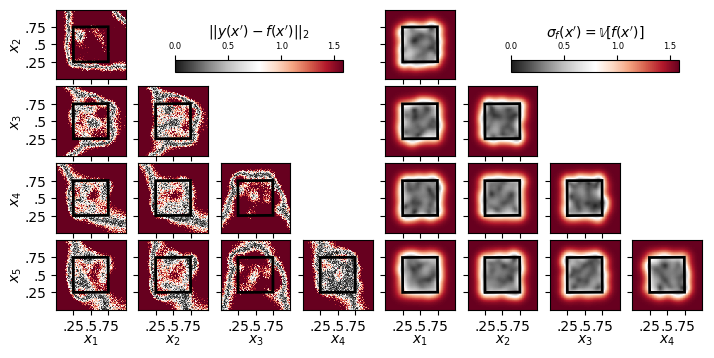

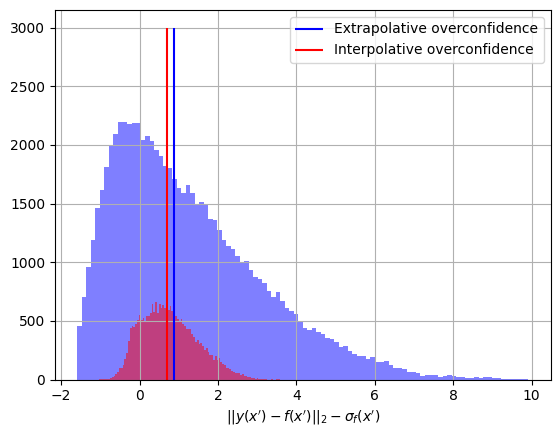

In [12]:
from scipy.interpolate import LinearNDInterpolator
import matplotlib.patches as patches

ovr_within = []
ovr_out = []

fig, ax = plt.subplots(nrows=dim - 1, ncols=2 * (dim - 1), figsize=(8.4,3.9), 
                       sharex=True, sharey=True)
planes = list(combinations(np.arange(5),2))
x_cross = 0.5
M = 100

for plane_coordinates in planes:
    x = np.linspace(0,1,M)
    y = np.linspace(0,1,M)
    
    xx, yy = np.meshgrid(x,y)
    X = x_cross * np.ones((M*M,dim))
    X[:,plane_coordinates[0]] = xx.flatten()
    X[:,plane_coordinates[1]] = yy.flatten()
    f, sigma_f = trained_gp_conf.predict(X, return_std=True)
    f = f.reshape(M,M)
    Y = noisy_friedman(X,sigma=sigma)
    Y = Y-np.mean(Y)
    Y = Y.reshape(M,M)
    error = np.sqrt(squared_error(Y,f))
    sigma_f = sigma_f.reshape(M,M)
    within_points = (np.sum(np.logical_and(X>lbound[0], X<ubound[0]),1)==dim).reshape(M,M)
    out_points = (np.sum(np.logical_and(X>lbound[0], X<ubound[0]),1)!=dim).reshape(M,M)
    ovr_within.append(error[within_points].flatten()-sigma_f[within_points].flatten())
    ovr_out.append(error[out_points].flatten()-sigma_f[out_points].flatten())    
    
    i, j = plane_coordinates[1] - 1, plane_coordinates[0]
    ax[i,j].grid(False)
    ax[i,j].set_box_aspect(1)
    ax[i,dim - 1 + j].grid(False)
    ax[i,dim - 1 + j].set_box_aspect(1)
    
    im = ax[i,j].pcolormesh(xx,yy,error, cmap="RdGy_r", shading='auto',vmin=0,vmax=np.max(sigma_f),
                            rasterized=True)
    train_region = patches.Rectangle((lbound[0],lbound[0]),ubound[0]-lbound[0],ubound[0]-lbound[0],
                                     np.max(np.abs(X_train))/2,edgecolor='k', linewidth=2,facecolor='none')
    ax[i,j].add_patch(train_region)
    im2 = ax[i, dim-1+j].pcolormesh(xx,yy,sigma_f, cmap="RdGy_r",shading='auto',vmin=0,
                            rasterized=True)
    train_region2 = patches.Rectangle((lbound[0],lbound[0]),ubound[0]-lbound[0],ubound[0]-lbound[0],
                                      np.max(np.abs(X_train))/2,edgecolor='k', linewidth=2,facecolor='none')
    ax[i,dim-1+j].add_patch(train_region2)    
    
    for a in [ax[:,:dim-1], ax[:, dim-1:]]:
        a[i,j].yaxis.set_ticks(np.arange(0.25, 1, 0.25))
        a[i,j].yaxis.set_major_formatter(major_formatter)
        a[i,j].xaxis.set_ticks(np.arange(0.25, 1, 0.25))
        a[i,j].xaxis.set_major_formatter(major_formatter)
    
ax[0,0].set_xlim([0,1])
ax[0,0].set_ylim([0,1])

for j in range(dim-1):
    ax[-1,j].set_xlabel(rf"$x_{j+1}$", color="k")
    ax[j,0].set_ylabel(rf"$x_{j+2}$", color="k")
    ax[-1,j].xaxis.labelpad=0
    ax[-1,dim-1+j].set_xlabel(rf"$x_{j+1}$", color="k")
    ax[-1,dim-1+j].xaxis.labelpad=0
    ax[j,0].yaxis.labelpad=0
    
for a in [ax[:,:dim-1], ax[:, dim-1:]]:
    for aa in a[np.triu_indices(dim - 1, 1)]:
        aa.axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.27, 0.72, 0.2, 0.03])
cbar_ax2 = fig.add_axes([0.67, 0.72, 0.2, 0.03])
label = [r"$||y(x')-f(x')||_2$", r"$\sigma_f(x')=\mathbb{V}[f(x')]$"]
ims = [im, im2]
for cbar_a,l,im in zip([cbar_ax, cbar_ax2],label, ims):
    cbar_a.grid(False)
    cbar = fig.colorbar(im, cax=cbar_a, orientation="horizontal")
    cbar.set_label(l)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.ax.xaxis.tick_top()
    cbar.ax.tick_params(labelsize=6)

save = False
if save:
    fig.savefig(save_dir + f"friedman_overconfidence_gps_x_{x_cross:.2f}.pdf",
                bbox_inches="tight",dpi=1000,pad_inches = 0.01)
else:
    plt.show()
    
ovr_extr = np.concatenate(ovr_out)
ovr_intrp = np.concatenate(ovr_within)
plt.figure()
plt.hist(ovr_extr,100,alpha=0.5,color='b')
plt.vlines(np.median(ovr_extr),0,3000,'b')
plt.hist(ovr_intrp,100,alpha=0.5,color='r')
plt.vlines(np.median(ovr_intrp),0,3000,'r')
plt.legend(['Extrapolative overconfidence', 'Interpolative overconfidence'])
plt.xlabel(r"$||y(x')-f(x')||_2 - \sigma_f(x')$")
plt.grid('on')
if save:
    plt.savefig(save_dir+f"friedman_overconfidence_gps_hist_{x_cross:.2f}.pdf")

## Legendre example

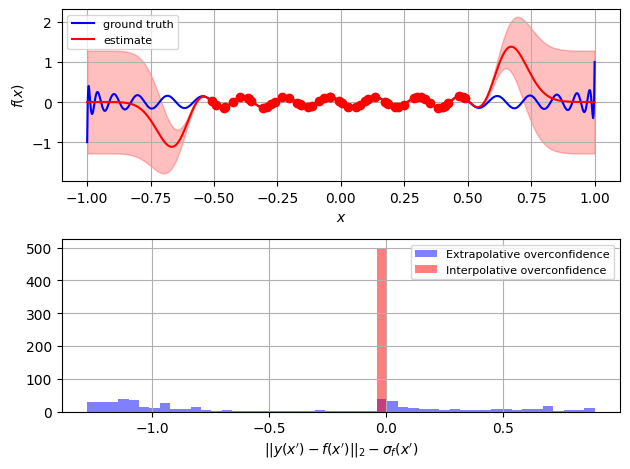

In [13]:
from scipy.special import eval_chebyc, eval_legendre, eval_chebys
order = 35
t_points = 50
train_bounds = 0.5
x_train = np.linspace(-train_bounds,train_bounds,t_points).reshape(-1,1) + 1e-2*np.random.randn(t_points,1)
y_train = eval_legendre(order, x_train)
x_test = np.linspace(-1,1,1000).reshape(-1,1)
y_test = eval_legendre(order,x_test)

kernel = ConstantKernel(constant_value=1)*RBF(length_scale=1e-1)#+WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5).fit(x_train,y_train)
out, std = gp.predict(x_test,return_std=True)

within = np.logical_and(x_test>-train_bounds,x_test<train_bounds)
outside = np.logical_or(x_test<-train_bounds,x_test>train_bounds)
within_err = np.sqrt(squared_error(out[within],y_test[within]))-std[within[:,0]]
out_err = np.sqrt(squared_error(out[outside],y_test[outside]))-std[outside[:,0]]

fig=plt.figure()
plt.subplot(211)
plt.plot(x_test,y_test,'b')
plt.plot(x_test,out,'r')
plt.fill_between(x_test[:,0], out[:,0]-std, out[:,0]+ std,alpha=0.25,color='r')
plt.plot(x_train,y_train,'ro')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(['ground truth','estimate'],prop={'size': 8})
plt.grid('on')
plt.subplot(212)
plt.hist(out_err,np.linspace(np.min(out_err),np.max(out_err)),alpha=0.5,color='b')
# plt.vlines(np.median(out_err),0,30,'b')
plt.hist(within_err,np.linspace(np.min(out_err),np.max(out_err)),alpha=0.5,color='r')
# plt.vlines(np.median(within_err),0,30,'r')
plt.legend(['Extrapolative overconfidence', 'Interpolative overconfidence'],prop={'size': 8})
plt.xlabel(r"$||y(x')-f(x')||_2 - \sigma_f(x')$")
plt.grid('on')
plt.tight_layout()
if save:
    fig.savefig(save_dir + "legendre_overconfidence_"+str(t_points)+".pdf",
            bbox_inches="tight",dpi=1000,pad_inches = 0.01)